# Super Simple Keras model on TriFeature for multiplicity determination

In [1]:
# For this network, GPU is slower than CPU -> Disable CUDA
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import numpy as np
import pandas as pd
import keras
import sys

sys.path.append("..")
from helpers import filename_for

print(keras.__version__)

Using TensorFlow backend.


Welcome to JupyROOT 6.16/00
2.3.1


In [3]:
num_dp = 30
max_neutrons = 4
label = "nPH"

In [4]:
files = [
    filename_for(15, 30, 600, 500, n, "inclxx", s, "trifeature.pkl")
    for n in range(1, max_neutrons + 1)
    for s in range(20)
]
dfs = [pd.read_pickle(file) for file in files]
data = pd.concat(dfs, ignore_index=True).sample(frac=1)
print(data.shape)

(800000, 6)


In [5]:
msk = np.random.rand(len(data)) < 0.8
# Create one entry with zero everything to prevent NaN-PDF if no entry with LABEL=0 exists
msk[0] = True
data.loc[0] = [0, 0, 0, 0, 0, 0]
traindata = data[msk]
testdata = data[~msk]

x_train = traindata[["nHits", "nClus", "Edep"]].values
y_train = keras.utils.to_categorical(traindata[[label]].values.ravel())

print(x_train)
print(y_train)

[[  45   11 1023]
 [  68   39 1080]
 [  49   18 1072]
 ...
 [  48    4  913]
 [  58   17  954]
 [  35   17  826]]
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


In [6]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=24, activation="relu", input_shape=(3,)))
model.add(keras.layers.Dense(units=9, activation="relu"))
model.add(keras.layers.Dense(units=max_neutrons + 1, activation="softmax"))

optimizer = keras.optimizers.Adagrad()
loss = keras.losses.categorical_crossentropy
model.compile(loss=loss, optimizer=optimizer, metrics=["acc"])

history = model.fit(x=x_train, y=y_train, batch_size=1000, epochs=100)

Epoch 1/100
640340/640340 [==============================] - 18s 28us/step - loss: 3.1579 - acc: 0.3199
Epoch 2/100
640340/640340 [==============================] - 16s 24us/step - loss: 1.1527 - acc: 0.4181
Epoch 3/100
640340/640340 [==============================] - 15s 24us/step - loss: 1.0320 - acc: 0.5287
Epoch 4/100
640340/640340 [==============================] - 12s 19us/step - loss: 0.8853 - acc: 0.6316
Epoch 5/100
640340/640340 [==============================] - 14s 22us/step - loss: 0.7886 - acc: 0.7020
Epoch 6/100
640340/640340 [==============================] - 16s 25us/step - loss: 0.7396 - acc: 0.7223
Epoch 7/100
640340/640340 [==============================] - 15s 24us/step - loss: 0.6962 - acc: 0.7450
Epoch 8/100
640340/640340 [==============================] - 16s 25us/step - loss: 0.6742 - acc: 0.7426
Epoch 9/100
640340/640340 [==============================] - 16s 25us/step - loss: 0.6440 - acc: 0.7627
Epoch 10/100
640340/640340 [==============================] - 15

2020-05-14 14:52:52.261037: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /data/jmayer/Simulations/R3BRoot/build/lib:/data/jmayer/Simulations/2019-09-04/ucesb/hbook:/data/jmayer/Simulations/2019-09-04/FairRoot/lib:/data/jmayer/Simulations/2019-09-04/FairSoft/lib/root:/data/jmayer/Simulations/2019-09-04/FairSoft/lib
2020-05-14 14:52:52.261210: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: UNKNOWN ERROR (303)
2020-05-14 14:52:52.261281: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (thanatos.ikp.uni-koeln.de): /proc/driver/nvidia/version does not exist
2020-05-14 14:52:52.262112: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020

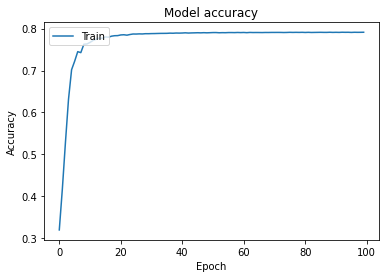

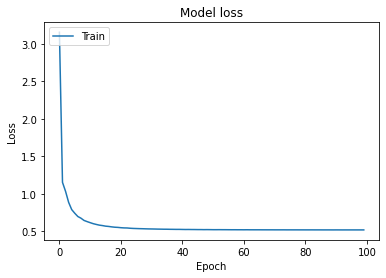

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history["acc"])
# plt.plot(history.history["val_acc"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

# Plot training & validation loss values
plt.plot(history.history["loss"])
# plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

In [11]:
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

x_test = testdata[["nHits", "nClus", "Edep"]].values
y_true = testdata[[label]].values.ravel()

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

bac = balanced_accuracy_score(y_true, y_pred)
print(bac)
cm = confusion_matrix(y_true, y_pred, labels=range(0, max_neutrons + 1))
print(cm)
cmrel = confusion_matrix(y_true, y_pred, labels=range(0, max_neutrons + 1), normalize="true")
print(cmrel)

0.8263725540902394
[[ 2044     0     0     0     1]
 [    0 39999  2009    12     2]
 [    0  4996 33292  3480    12]
 [    0   221  8221 29705  2907]
 [    0     6   636 10493 21624]]
[[1.    0.    0.    0.    0.   ]
 [0.    0.952 0.048 0.    0.   ]
 [0.    0.12  0.797 0.083 0.   ]
 [0.    0.005 0.2   0.724 0.071]
 [0.    0.    0.019 0.32  0.66 ]]


Text(69.0, 0.5, 'True')

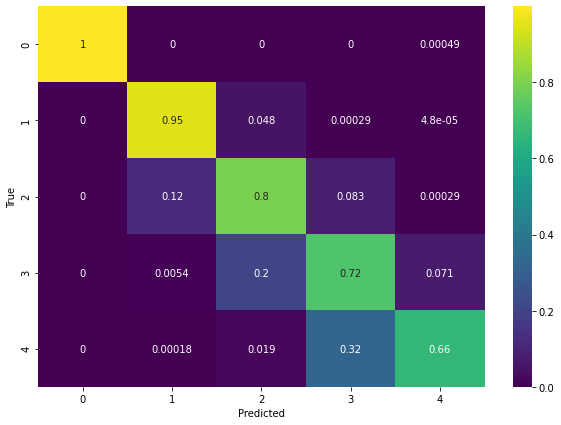

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cmrel, cmap="viridis", annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")